In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
def get_timeseries(df):
    data = [] #frame,sign
    for frame in range(1, df['frame'].values.max()+1):        
        df_filter = df[df['frame']==frame]
        if df_filter.shape[0] >0:
            row = df_filter.iloc[0]
            data.append([int(row.frame),int(row.sign)])
        else:
            data.append([int(frame),0])
    return pd.DataFrame(data,columns=['frame','sign'])

def get_timeseries_prob(df):
    data = np.zeros((7,df['frame'].values.max()+1))
    for frame in range(1, df['frame'].values.max()+1):
        df_filter = df[df['frame']==frame]
        if df_filter.shape[0] >0:
            row = df_filter.iloc[0]
            sign_int = int(row.sign) -1
            data[sign_int][frame] = row.prob
    return data

def get_sequence(df, clean_zeros=True):
    frames = [0]
    repetitions = [0]
    signs = [0]

    for index, row in df.iterrows():
        if row.sign == signs[-1]:
            repetitions[-1] += 1
        else:
            frames.append(row.frame)
            repetitions.append(1)
            signs.append(row.sign)
            
    if clean_zeros:
        a = np.array(signs)
        frames = np.array(frames)[a != 0].tolist()
        repetitions = np.array(repetitions)[a != 0].tolist()
        signs = np.array(signs)[a != 0].tolist()
        return frames, repetitions, signs
    else:
        return frames[1:], repetitions[1:], signs[1:]
    
def fill_holes(df_complete):
    #Fill holes (no detection between same sign)
    data = np.array([[0,0]]) #frame,sign
    previous = [0,0]
    frames = [0,0]
    for index, row in df_complete.iterrows():
        if row.sign == previous[-1]:
            frames[-1] += 1
            data = np.append(data,[[row.frame, row.sign]],axis=0)
        else:        
            if previous[-1] == 0 and previous[-2]==row.sign:
                n_frames = frames[-1]
                for i in range(1, n_frames+1):
                    data[-i] = [row.frame-i,row.sign]
                previous = previous[:-1]            
                frames = frames[:-1]
                frames[-1] += n_frames
            else:
                previous.append(row.sign)
                frames.append(1)
            data = np.append(data,[[row.frame, row.sign]],axis=0)
    return pd.DataFrame(data[1:], columns=['frame', 'sign'])

In [3]:
sequences = [f for f in os.listdir('sos_sequences') if f.endswith('.csv')]

In [4]:
df_users = pd.read_csv('users.csv')
df_users.head()

,name_folder,user_id,sex,train
0,adrian,user01,0,1
1,alexis,user02,0,1
2,bea,user03,1,1
3,camino,user04,1,1
4,claudia,user05,1,1


In [5]:
colors= ['white','gray', 'navy','gold', 'green', 'blue', 'red', 'orange']
markers = ['o', '8','<', '>', 'p', '*', '^', 'v']
sign_labels = ['S'+str(i) for i in range(1,8) ]

custom_lines = [Line2D([0], [0], color=color, lw=0, marker=marker, markersize=10) for color,marker in zip(colors[1:],markers[1:])]

In [6]:
def get_events(dfs):
    frames = []
    signs = []
    classes = []
    for df in dfs:
        frames.append(df['frame'].values)
        signs.append(df['sign'].values)
        classes.append([colors[i] for i in df['sign'].values.astype(np.int32)])
    return frames, signs, classes

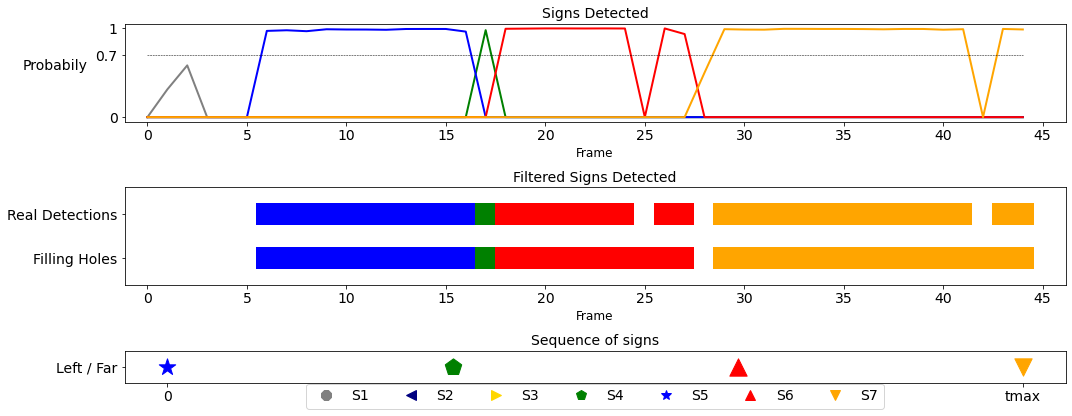

In [7]:
fontsize=14

seq_user = [f for f in sequences if 'user10' in f]
seq_user.sort()

labels = []
dfs_complete = []
dfs_holes = []
dfs = []
for i in range(4):
    sequence = seq_user[i]
    info = sequence.split('_')
    hand = 'Left'  if info[2][0]== 'l' else 'Right'
    distance = 'Near'  if info[2][1]== 'n' else 'Far'
    labels.append(hand+' / '+distance)
    
    df = pd.read_csv('sos_sequences/'+sequence, dtype={'prob': np.float64, 'frame': np.int32, 'sign': np.int32})
    dfs.append(df)
    df_filter = df[df['prob']>0.7]
    df_complete = get_timeseries(df_filter)
    df_holes = fill_holes(df_complete)
    
    dfs_complete.append(df_complete)
    dfs_holes.append(df_holes)   
    
frames, signs, classes = get_events(dfs_complete)
frames2, signs2, classes2 = get_events(dfs_holes)


fig, axs = plt.subplots(3,1, figsize=(15,6),gridspec_kw={'height_ratios': [3,3,1]})

axs[0].set_title('Signs Detected',fontsize=fontsize)

data = get_timeseries_prob(dfs[0])
for i in range(7):
    axs[0].plot(data[i], label='S'+str(i), color=colors[i+1], linewidth=2)
axs[0].set_xlabel('Frame', fontsize=fontsize-2)
axs[0].plot([0,max(frames2[0])], [0.7,0.7], color='black', linestyle = '--', linewidth=0.5)
axs[0].set_yticks([0,0.7,1])
axs[0].set_yticklabels([0,0.7,1], fontsize=fontsize)
axs[0].set_ylabel('Probabily', fontsize=fontsize, rotation=0, labelpad=40)

axs[1].set_title('Filtered Signs Detected',fontsize=fontsize)
axs[1].eventplot([frames2[0], frames[0]], colors=[classes2[0], classes[0]], linewidth=22, linelengths=0.5)
axs[1].set_yticks(range(2))
axs[1].set_yticklabels(['Filling Holes', 'Real Detections'], fontsize=fontsize)
axs[1].set_xticks(np.arange(0,max(frames2[0])+4,5))
axs[1].set_xticklabels(np.arange(0,max(frames2[0])+4,5), fontsize=fontsize)
axs[1].set_xlabel('Frame', fontsize=fontsize-2)

axs[0].sharex(axs[1])
axs[0].set_xticklabels(np.arange(0,max(frames2[0])+4,5), fontsize=fontsize)

axs[2].set_title('Sequence of signs',fontsize=fontsize)
data = np.array([])
values = np.array([])
order = np.array([])
_, _, signs = get_sequence(dfs_holes[0], clean_zeros=True)
values = np.append(values,np.ones(len(signs)))
data = np.append(data,[colors[i] for i in signs])
order = np.append(order, range(len(signs)))

for i in range(1,8):
    color = colors[i]
    v_sign = values[data==color]
    d_sign = data[data==color]
    o_sign = order[data==color]
    axs[2].scatter(o_sign,v_sign, c=d_sign, marker=markers[i], s=300)
axs[2].set_yticks([1])
axs[2].set_yticklabels([labels[0]],fontsize=fontsize)
axs[2].set_xticks([0, len(signs)-1])
axs[2].set_xticklabels([0, 'tmax'],fontsize=fontsize)
plt.legend(custom_lines, sign_labels,ncol=7, loc='lower center',fontsize=fontsize, bbox_to_anchor=(0.5, -1))

plt.tight_layout()
plt.savefig('results/img_process_holes_sequence.pdf', bbox_inches='tight', dpi=300)
plt.show()

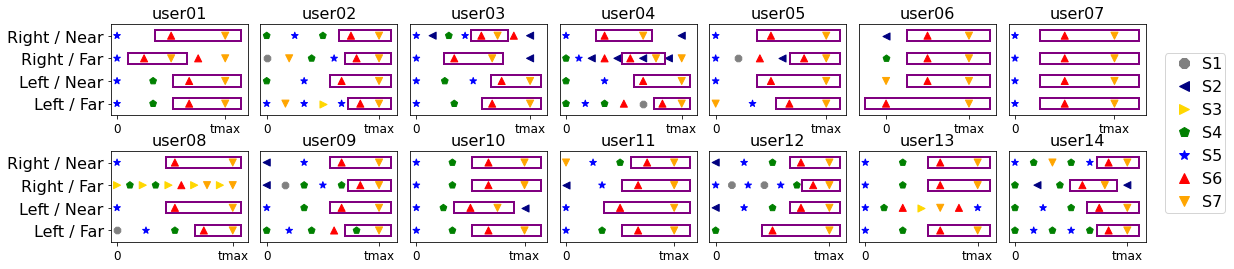

In [8]:
fontsize = 16 

fig, ax = plt.subplots(2,8, figsize=(20,4),gridspec_kw={'width_ratios': [1,1,1,1,1,1,1,0.5]})

gs = ax[1, 2].get_gridspec() 
for axs in ax[:, 7]:
    axs.remove()
axsbig = fig.add_subplot(gs[:, 7])
axsbig.axis('off')

for index, row in df_users.iterrows():
    seq_user = [f for f in sequences if row.user_id in f]
    user_id = int(row.user_id[-2:]) -1
    seq_user.sort()

    labels = []
    
    dfs_holes = []
    final = []
    max_size = 1
    for i in range(4):
        sequence = seq_user[i]
        info = sequence.split('_')
        hand = 'Left'  if info[2][0]== 'l' else 'Right'
        distance = 'Near'  if info[2][1]== 'n' else 'Far'
        labels.append(hand+' / '+distance)

        df = pd.read_csv('sos_sequences/'+sequence, dtype={'prob': np.float64, 'frame': np.int32, 'sign': np.int32})
        df_filter = df[df['prob']>0.7]
        df_complete = get_timeseries(df_filter)
        #df_complete = get_timeseries(df)
        df_holes = fill_holes(df_complete)

        dfs_holes.append(df_holes)  
        _, _, signs = get_sequence(df_holes, clean_zeros=True)
        final.append(signs)
        if len(signs)>max_size:
            max_size = len(signs)
            
    c = int(user_id%7)
    r = int(user_id / 7)
    ax[r][c].set_title(row.user_id, fontsize=fontsize)
    
    data = np.array([]) #colors == sign
    values = np.array([]) # height == video
    order = np.array([]) # x axis
    rectangles = []
    for i in range(4):
        orders = np.linspace(0,max_size, len(final[i]))
        values = np.append(values,np.ones(len(final[i]))*i)
        order = np.append(order, orders)
        data = np.append(data,[colors[i] for i in final[i]])
        
        
        chars = ''.join([str(elem) for elem in final[i]])
        #ind = [chars.find('467'), chars.find('567'), chars.find('547'), chars.find('5647'), chars.find('4647'), chars.find('4627')]
        #sizes = [3,3,3,4,4,4]
        
        ind = [chars.find('67'), chars.find('57'), chars.find('47'), chars.find('627')]
        sizes = [2,2,2,3]
        ind_max = max(ind) 
        max_ind = ind.index(ind_max)
        
        if ind_max>=0:
            width = orders[ind_max+sizes[max_ind]-1] - orders[ind_max]
            rect=mpatches.Rectangle((orders[ind_max]-0.75,-0.25+i),width+1.5,0.5, fill=False, color="purple",linewidth=2)
            ax[r][c].add_patch(rect)

    for i in range(1,8):
        color = colors[i]
        v_sign = values[data==color]
        d_sign = data[data==color]
        o_sign = order[data==color]
        ax[r][c].scatter(o_sign,v_sign, c=d_sign, marker=markers[i], s=50)
    
    ax[r][c].set_ylim(-0.5,3.5)
    ax[r][c].set_xticks([0, max_size])
    ax[r][c].set_xticklabels([0, 'tmax'],fontsize=fontsize-4)
    if c==0:
        ax[r][c].set_yticks(range(len(labels)))
        ax[r][c].set_yticklabels(labels,fontsize=fontsize)
    else:
        ax[r][c].set_yticks([])
    #plt.yticks(sequences[:1])

axsbig.legend(custom_lines, sign_labels,loc='center right',fontsize=fontsize, handletextpad=0.1, borderaxespad=0.1, borderpad=0.2)
plt.subplots_adjust(wspace=0.1, hspace=0.4)


#plt.tight_layout()
plt.savefig('results/img_users_sequence.pdf', bbox_inches='tight', dpi=300)
plt.show()